# Install Necessary Libraries

In [1]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade scikit-learn imbalanced-learn optuna joblib matplotlib pandas numpy

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\python\python.exe -m pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Configuration and Optimization (For Realistic Mode)

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, classification_report,
    matthews_corrcoef, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import joblib
import optuna
from optuna.samplers import TPESampler

# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODE = "realistic"       # "realistic" drops CA/PA, "full" keeps them
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
N_TRIALS = 100


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# drop CA/PA if realistic
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

if 'Age' in df.columns:
    df['Age_Group_Young'] = (df['Age'] <= 20).astype(int)
    df['Age_Group_Peak'] = ((df['Age'] > 20) & (df['Age'] <= 23)).astype(int)

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# ==============================================================================
# SMOTE + Logistic Regression with Optuna (optimized for imbalance)
# ==============================================================================

def objective(trial):
    # -----------------------------
    # SMOTE level
    # -----------------------------
    smote_level = trial.suggest_categorical("smote_level", ["small", "medium", "high"])
    smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[smote_level]

    # -----------------------------
    # Solver and penalty logic
    # -----------------------------
    solver = trial.suggest_categorical("solver", ["lbfgs", "saga"])
    if solver == "lbfgs":
        penalty = "l2"
        l1_ratio = None
    else:
        penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0) if penalty == "elasticnet" else None

    # -----------------------------
    # Regularization & iterations
    # -----------------------------
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    max_iter = trial.suggest_int("max_iter", 500, 2000)

    # -----------------------------
    # Build pipeline
    # -----------------------------
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)
    pipe = ImbPipeline([
        ("smote", smote),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            random_state=SEED,
            solver=solver,
            penalty=penalty,
            l1_ratio=l1_ratio,
            C=C,
            max_iter=max_iter,
            class_weight="balanced",  
            n_jobs=-1
        ))
    ])

    # -----------------------------
    # Fit and evaluate
    # -----------------------------
    pipe.fit(X_train, y_train)
    y_val_proba = pipe.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= 0.5).astype(int)
    return balanced_accuracy_score(y_val, y_val_pred)


# -----------------------------
# Run Optuna study
# -----------------------------
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=SEED),
    study_name="LR_Realistic"
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params = study.best_params
print("\nBest Hyperparameters:", best_params)

# -----------------------------
# FINAL PIPELINE (Train + Validation)
# -----------------------------
best_smote = SMOTE(
    sampling_strategy={"small": 0.2, "medium": 0.5, "high": 1.0}[best_params["smote_level"]],
    random_state=SEED
)

solver_final = best_params["solver"]

if solver_final == "lbfgs":
    penalty_final = "l2"
    l1_ratio_final = None
else:
    penalty_final = best_params["penalty"]
    if penalty_final == "elasticnet":
        l1_ratio_final = best_params.get("l1_ratio", 0.5) 
    else:
        l1_ratio_final = None

final_pipe = ImbPipeline([
    ("smote", best_smote),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        random_state=SEED,
        solver=solver_final,
        C=best_params["C"],        
        penalty=penalty_final,
        l1_ratio=l1_ratio_final,
        max_iter=best_params["max_iter"],
        class_weight="balanced",
        n_jobs=-1
    ))
])

# Train final model on combined training + validation
final_pipe.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

Reading file...


[I 2025-12-06 19:59:52,736] A new study created in memory with name: LR_Realistic


Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=realistic -> Dropped CA and PA

Features: 65  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-06 19:59:57,124] Trial 0 finished with value: 0.8238865337310933 and parameters: {'smote_level': 'medium', 'solver': 'lbfgs', 'C': 0.20781011670611516, 'max_iter': 819}. Best is trial 0 with value: 0.8238865337310933.
[I 2025-12-06 20:00:00,570] Trial 1 finished with value: 0.8288683466792275 and parameters: {'smote_level': 'small', 'solver': 'lbfgs', 'C': 0.03254086179174597, 'max_iter': 972}. Best is trial 1 with value: 0.8288683466792275.
[I 2025-12-06 20:00:07,552] Trial 2 finished with value: 0.8239650389909458 and parameters: {'smote_level': 'medium', 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.3976772847734955, 'C': 1.5064347935642368, 'max_iter': 849}. Best is trial 1 with value: 0.8288683466792275.
[I 2025-12-06 20:00:10,956] Trial 3 finished with value: 0.8158048533696203 and parameters: {'smote_level': 'high', 'solver': 'lbfgs', 'C': 0.2591250623964081, 'max_iter': 1032}. Best is trial 1 with value: 0.8288683466792275.
[I 2025-12-06 20:00:14,525] Tria

,steps,"[('smote', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,0.2
,random_state,67
,k_neighbors,5
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'


# Plot The Visualization History for the Optuna Realistic Mode

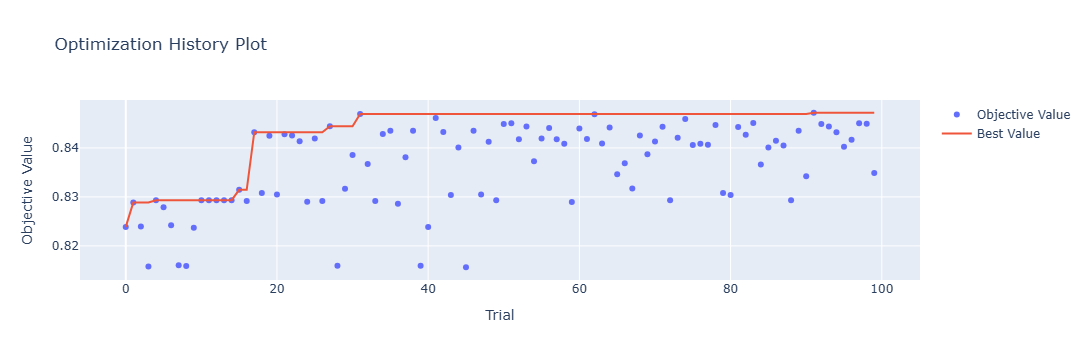

In [4]:
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.write_html("optimization_history_realistic.html")
fig1.show()

# Best Tuned Hyperparamter on Realistic Mode

In [5]:
print(study.best_value)
best_params

0.8471873309956212


{'smote_level': 'small',
 'solver': 'lbfgs',
 'C': 0.0021115498112044186,
 'max_iter': 1527}

# FINAL EVALUATION ON TEST (with both thresholds) for the Realistic Mode

In [6]:
# ==============================================================================
# FINAL EVALUATION ON TEST (with both thresholds)
# ==============================================================================

# Predict probabilities on the test set
y_test_pred_prop = final_pipe.predict_proba(X_test)[:, 1]

# Initialize thresholds
thresholds = {"F1": None, "Balanced_Accuracy": None}
best_f1 = 0
best_bal = 0

# Search for thresholds
for t in np.arange(0.1, 0.91, 0.01):
    y_pred_t = (y_test_pred_prop >= t).astype(int)

    # F1 score
    f1_t = f1_score(y_test, y_pred_t)
    if f1_t > best_f1:
        best_f1 = f1_t
        thresholds["F1"] = t

    # Balanced Accuracy
    bal_t = balanced_accuracy_score(y_test, y_pred_t)
    if bal_t > best_bal:
        best_bal = bal_t
        thresholds["Balanced_Accuracy"] = t

# Predictions using both thresholds
y_pred_f1 = (y_test_pred_prop >= thresholds['F1']).astype(int)
y_pred_bal = (y_test_pred_prop >= thresholds['Balanced_Accuracy']).astype(int)

# Metrics for both thresholds
metrics_f1 = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_f1),
    "precision": precision_score(y_test, y_pred_f1),
    "recall": recall_score(y_test, y_pred_f1),
    "f1": f1_score(y_test, y_pred_f1),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop),
    "geometric_mean": geometric_mean_score(y_test, y_pred_f1),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_f1),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_f1)
}

metrics_bal = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_bal),
    "precision": precision_score(y_test, y_pred_bal),
    "recall": recall_score(y_test, y_pred_bal),
    "f1": f1_score(y_test, y_pred_bal),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop),
    "geometric_mean": geometric_mean_score(y_test, y_pred_bal),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_bal),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_bal)
}

# Print results for both thresholds
print("\nFINAL EVALUATION ON TEST SET")
print("="*70)

# --- F1-optimal threshold ---
print(f"\nUsing F1 Threshold ({thresholds['F1']:.3f})")
print(f"Balanced Accuracy: {metrics_f1['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_f1['precision']:.4f}")
print(f"Recall: {metrics_f1['recall']:.4f}")
print(f"F1 Score: {metrics_f1['f1']:.4f}")
print(f"ROC-AUC: {metrics_f1['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_f1['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_f1['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_f1['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_f1))
print("\nClassification Report:\n", classification_report(y_test, y_pred_f1))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_f1))

# --- Balanced Accuracy-optimal threshold ---
print(f"\nUsing Balanced Accuracy Threshold ({thresholds['Balanced_Accuracy']:.3f})")
print(f"Balanced Accuracy: {metrics_bal['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_bal['precision']:.4f}")
print(f"Recall: {metrics_bal['recall']:.4f}")
print(f"F1 Score: {metrics_bal['f1']:.4f}")
print(f"ROC-AUC: {metrics_bal['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_bal['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_bal['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_bal['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_bal))

# Save results
model_dict = {
    "best_params": best_params,
    "thresholds": thresholds,
    "metrics_f1": metrics_f1,
    "metrics_balanced_accuracy": metrics_bal,
    "study": study,
    "model": final_pipe
}

joblib.dump(model_dict, "LR_realistic_model.pkl")


FINAL EVALUATION ON TEST SET

Using F1 Threshold (0.840)
Balanced Accuracy: 0.6874
Precision: 0.2834
Recall: 0.4101
F1 Score: 0.3352
ROC-AUC: 0.9161
Geometric Mean: 0.6290
Matthews Corr: 0.3140
Cohen Kappa: 0.3083

Confusion Matrix:
 [[6144  225]
 [ 128   89]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      6369
           1       0.28      0.41      0.34       217

    accuracy                           0.95      6586
   macro avg       0.63      0.69      0.65      6586
weighted avg       0.96      0.95      0.95      6586


Imbalanced Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.96      0.41      0.97      0.63      0.42      6369
          1       0.28      0.41      0.96      0.34      0.63      0.37       217

avg / total       0.96      0.95      0.43      0.95      0.63      0.42      6586


Using Balanced Accuracy Thres

['LR_realistic_model.pkl']

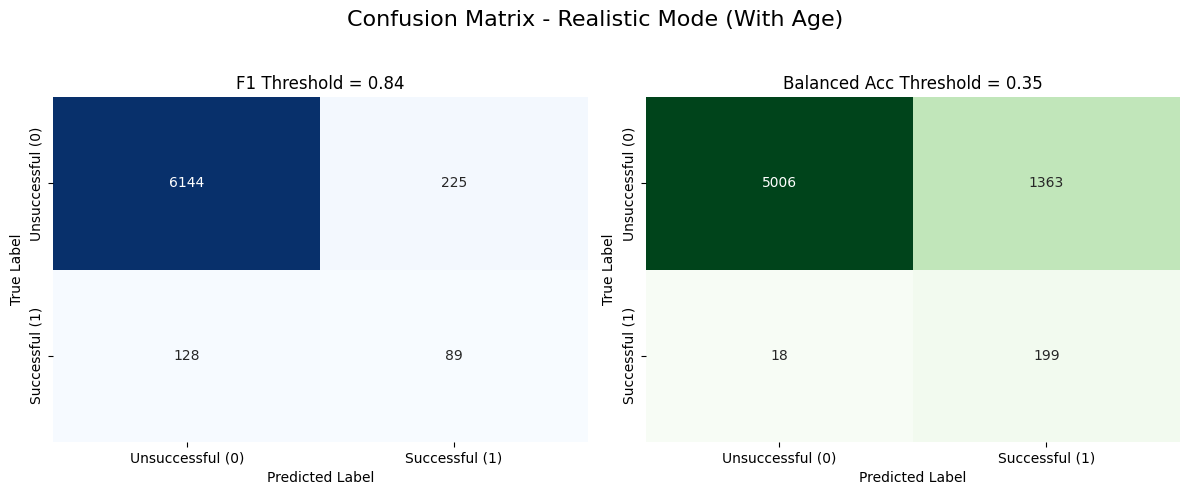

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# CONFUSION MATRIX PLOTS SIDE BY SIDE
# ==============================================================================

# Compute confusion matrices
cm_f1 = confusion_matrix(y_test, y_pred_f1)
cm_bal = confusion_matrix(y_test, y_pred_bal)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# F1 Threshold
sns.heatmap(cm_f1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[0])
axes[0].set_title(f"F1 Threshold = {thresholds['F1']:.2f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

#  Balanced Accuracy Threshold 
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[1])
axes[1].set_title(f"Balanced Acc Threshold = {thresholds['Balanced_Accuracy']:.2f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Overall title
plt.suptitle("Confusion Matrix - Realistic Mode (With Age)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("Confusion Matrix - Realistic Mode")
plt.show()

# Data Configuration and Optimization (For Full Mode)

In [8]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, classification_report,
    matthews_corrcoef, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import joblib
import optuna
from optuna.samplers import TPESampler

# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODE = "full"       # "realistic" drops CA/PA, "full" keeps them
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
N_TRIALS = 100


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# drop CA/PA if realistic
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

if 'Age' in df.columns:
    df['Age_Group_Young'] = (df['Age'] <= 20).astype(int)
    df['Age_Group_Peak'] = ((df['Age'] > 20) & (df['Age'] <= 23)).astype(int)

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# ==============================================================================
# SMOTE + Logistic Regression with Optuna (optimized for imbalance)
# ==============================================================================

def objective(trial):
    # -----------------------------
    # SMOTE level
    # -----------------------------
    smote_level = trial.suggest_categorical("smote_level", ["small", "medium", "high"])
    smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[smote_level]

    # -----------------------------
    # Solver and penalty logic
    # -----------------------------
    solver = trial.suggest_categorical("solver", ["lbfgs", "saga"])
    if solver == "lbfgs":
        penalty = "l2"
        l1_ratio = None
    else:
        penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0) if penalty == "elasticnet" else None

    # -----------------------------
    # Regularization & iterations
    # -----------------------------
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    max_iter = trial.suggest_int("max_iter", 500, 2000)

    # -----------------------------
    # Build pipeline
    # -----------------------------
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)
    pipe = ImbPipeline([
        ("smote", smote),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            random_state=SEED,
            solver=solver,
            penalty=penalty,
            l1_ratio=l1_ratio,
            C=C,
            max_iter=max_iter,
            class_weight="balanced",  # crucial for severe imbalance
            n_jobs=-1
        ))
    ])

    # -----------------------------
    # Fit and evaluate
    # -----------------------------
    pipe.fit(X_train, y_train)
    y_val_proba = pipe.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_proba >= 0.5).astype(int)
    return balanced_accuracy_score(y_val, y_val_pred)


# -----------------------------
# Run Optuna study
# -----------------------------
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=SEED),
    study_name="LR_Full"
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params = study.best_params
print("\nBest Hyperparameters:", best_params)

# -----------------------------
# FINAL PIPELINE (Train + Validation)
# -----------------------------
best_smote = SMOTE(
    sampling_strategy={"small": 0.2, "medium": 0.5, "high": 1.0}[best_params["smote_level"]],
    random_state=SEED
)

solver_final = best_params["solver"]

if solver_final == "lbfgs":
    penalty_final = "l2"
    l1_ratio_final = None
else:
    penalty_final = best_params["penalty"]
    if penalty_final == "elasticnet":
        l1_ratio_final = best_params.get("l1_ratio", 0.5)
    else:
        l1_ratio_final = None

final_pipe = ImbPipeline([
    ("smote", best_smote),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        random_state=SEED,
        solver=solver_final,
        C=best_params["C"],          
        penalty=penalty_final,
        l1_ratio=l1_ratio_final,
        max_iter=best_params["max_iter"],
        class_weight="balanced",
        n_jobs=-1
    ))
])

# Train final model on combined training + validation
final_pipe.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

Reading file...


[I 2025-12-06 20:06:52,835] A new study created in memory with name: LR_Full


Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=full -> Keeping CA and PA

Features: 69  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-06 20:06:57,389] Trial 0 finished with value: 0.8095778597721603 and parameters: {'smote_level': 'medium', 'solver': 'lbfgs', 'C': 0.20781011670611516, 'max_iter': 819}. Best is trial 0 with value: 0.8095778597721603.
[I 2025-12-06 20:06:59,373] Trial 1 finished with value: 0.8345272674935886 and parameters: {'smote_level': 'small', 'solver': 'lbfgs', 'C': 0.03254086179174597, 'max_iter': 972}. Best is trial 1 with value: 0.8345272674935886.


C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:07:51,743] Trial 2 finished with value: 0.8102059018509795 and parameters: {'smote_level': 'medium', 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.3976772847734955, 'C': 1.5064347935642368, 'max_iter': 849}. Best is trial 1 with value: 0.8345272674935886.
[I 2025-12-06 20:07:54,013] Trial 3 finished with value: 0.8006729645330681 and parameters: {'smote_level': 'high', 'solver': 'lbfgs', 'C': 0.2591250623964081, 'max_iter': 1032}. Best is trial 1 with value: 0.8345272674935886.
[I 2025-12-06 20:07:56,673] Trial 4 finished with value: 0.8352763385146804 and parameters: {'smote_level': 'small', 'solver': 'lbfgs', 'C': 23.333722546834178, 'max_iter': 1600}. Best is trial 4 with value: 0.8352763385146804.
[I 2025-12-06 20:07:58,908] Trial 5 finished with value: 0.8167174770154044 and parameters: {'smote_level': 'medium', 'solver': 'lbfgs', 'C': 0.031208319905994247, 'max_iter': 957}. Best is trial 4 with value: 0.8352763385146804.
[I 2025-12-06 20:08:01,978] Tri

C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:09:30,511] Trial 10 finished with value: 0.8371179410687182 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 32.7857515677088, 'max_iter': 1771}. Best is trial 10 with value: 0.8371179410687182.


C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:10:43,817] Trial 11 finished with value: 0.8371179410687182 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 34.49754323018002, 'max_iter': 1766}. Best is trial 10 with value: 0.8371179410687182.


C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:12:08,244] Trial 12 finished with value: 0.837274951588423 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 48.43463651603853, 'max_iter': 2000}. Best is trial 12 with value: 0.837274951588423.


C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:13:34,360] Trial 13 finished with value: 0.837274951588423 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 199.24252430678712, 'max_iter': 1977}. Best is trial 12 with value: 0.837274951588423.


C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:15:04,226] Trial 14 finished with value: 0.837274951588423 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 223.6276485427705, 'max_iter': 1989}. Best is trial 12 with value: 0.837274951588423.


C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:15:28,716] Trial 15 finished with value: 0.8383336822455993 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 2.5640024346260057, 'max_iter': 527}. Best is trial 15 with value: 0.8383336822455993.


C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:15:51,918] Trial 16 finished with value: 0.8382551769857469 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 3.049934352195019, 'max_iter': 510}. Best is trial 15 with value: 0.8383336822455993.


C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:16:10,570] Trial 17 finished with value: 0.8360188674307845 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l2', 'C': 2.280809416931775, 'max_iter': 528}. Best is trial 15 with value: 0.8383336822455993.


C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:16:35,131] Trial 18 finished with value: 0.8383336822455993 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.9970095268750274, 'C': 3.817276048648384, 'max_iter': 562}. Best is trial 15 with value: 0.8383336822455993.
[I 2025-12-06 20:16:36,581] Trial 19 finished with value: 0.8674711275099876 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.9957183960011848, 'C': 0.0010253260433262029, 'max_iter': 688}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:16:38,318] Trial 20 finished with value: 0.8645304513180161 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.9819310573596219, 'C': 0.0016605921815200724, 'max_iter': 706}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:16:39,748] Trial 21 finished with value: 0.862018283002739 and parameters: {'smote_level': 'small', 'solver': 'saga', 'pena

C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:18:16,637] Trial 29 finished with value: 0.8003589434936585 and parameters: {'smote_level': 'high', 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.8026390658642795, 'C': 0.20786267046897852, 'max_iter': 618}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:18:38,866] Trial 30 finished with value: 0.8131084157638562 and parameters: {'smote_level': 'medium', 'solver': 'saga', 'penalty': 'l2', 'C': 0.08564483344580717, 'max_iter': 827}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:18:40,381] Trial 31 finished with value: 0.8654365328588127 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.8575010669791052, 'C': 0.002279711424530663, 'max_iter': 730}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:18:42,112] Trial 32 finished with value: 0.8639471136232795 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.844729

C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:19:57,023] Trial 35 finished with value: 0.8362543832103417 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.8454796235515998, 'C': 0.4326889377314546, 'max_iter': 1188}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:20:01,332] Trial 36 finished with value: 0.8387240278431989 and parameters: {'smote_level': 'small', 'solver': 'lbfgs', 'C': 0.00968808502037033, 'max_iter': 1030}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:20:32,101] Trial 37 finished with value: 0.8211900961253293 and parameters: {'smote_level': 'medium', 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.864591791222789, 'C': 0.025057426110477243, 'max_iter': 937}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:20:35,786] Trial 38 finished with value: 0.8327619894977408 and parameters: {'smote_level': 'small', 'solver': 'lbfgs', 'C': 0.07446001112245451, 'max_iter': 1017}. Best is trial 

C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:24:07,532] Trial 65 finished with value: 0.836882425289161 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 13.288859365424685, 'max_iter': 1471}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:24:09,303] Trial 66 finished with value: 0.8665759494775038 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 0.0035159734913435938, 'max_iter': 1419}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:24:29,042] Trial 67 finished with value: 0.8477074283421433 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 0.007776503838561478, 'max_iter': 1504}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:24:31,127] Trial 68 finished with value: 0.8616726417892221 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 0.0041937051413671956, 'max_iter': 1595}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-1

C:\python\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[I 2025-12-06 20:26:10,042] Trial 76 finished with value: 0.8364113937300466 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 84.15154751422371, 'max_iter': 1182}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:26:13,202] Trial 77 finished with value: 0.7925934648732575 and parameters: {'smote_level': 'medium', 'solver': 'lbfgs', 'C': 968.3145796784905, 'max_iter': 1693}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:26:16,311] Trial 78 finished with value: 0.8380959857643795 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l2', 'C': 0.00862156274522474, 'max_iter': 1080}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:26:18,048] Trial 79 finished with value: 0.8652413600600128 and parameters: {'smote_level': 'small', 'solver': 'saga', 'penalty': 'l1', 'C': 0.003105182735229028, 'max_iter': 1348}. Best is trial 19 with value: 0.8674711275099876.
[I 2025-12-06 20:26:19,596] Tr

,steps,"[('smote', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,0.2
,random_state,67
,k_neighbors,5
,copy,True
,with_mean,True
,with_std,True
,penalty,'elasticnet'


# Plot The Visualization History for the Optuna Full Mode

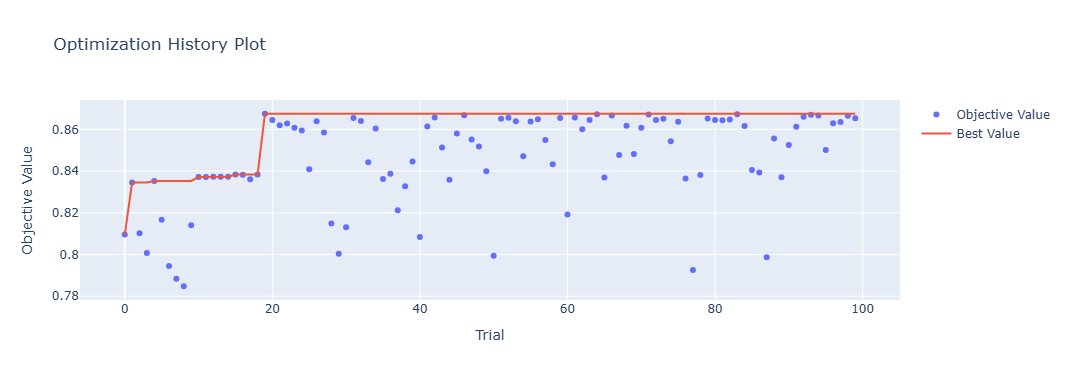

In [9]:
fig2 = optuna.visualization.plot_optimization_history(study)
fig2.write_html("optimization_history_full.html")
fig2.show()

# Best Tuned Hyperparamter on Full Mode

In [10]:
print(study.best_value)
best_params

0.8674711275099876


{'smote_level': 'small',
 'solver': 'saga',
 'penalty': 'elasticnet',
 'l1_ratio': 0.9957183960011848,
 'C': 0.0010253260433262029,
 'max_iter': 688}

# FINAL EVALUATION ON TEST (with both thresholds) for the Full Mode

In [11]:
# ==============================================================================
# FINAL EVALUATION ON TEST (with both thresholds)
# ==============================================================================

# Predict probabilities on the test set
y_test_pred_prop = final_pipe.predict_proba(X_test)[:, 1]

# Initialize thresholds
thresholds = {"F1": None, "Balanced_Accuracy": None}
best_f1 = 0
best_bal = 0

# Search for thresholds
for t in np.arange(0.1, 0.91, 0.01):
    y_pred_t = (y_test_pred_prop >= t).astype(int)

    # F1 score
    f1_t = f1_score(y_test, y_pred_t)
    if f1_t > best_f1:
        best_f1 = f1_t
        thresholds["F1"] = t

    # Balanced Accuracy
    bal_t = balanced_accuracy_score(y_test, y_pred_t)
    if bal_t > best_bal:
        best_bal = bal_t
        thresholds["Balanced_Accuracy"] = t

# Predictions using both thresholds
y_pred_f1 = (y_test_pred_prop >= thresholds['F1']).astype(int)
y_pred_bal = (y_test_pred_prop >= thresholds['Balanced_Accuracy']).astype(int)

# Metrics for both thresholds
metrics_f1 = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_f1),
    "precision": precision_score(y_test, y_pred_f1),
    "recall": recall_score(y_test, y_pred_f1),
    "f1": f1_score(y_test, y_pred_f1),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop),
    "geometric_mean": geometric_mean_score(y_test, y_pred_f1),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_f1),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_f1)
}

metrics_bal = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_bal),
    "precision": precision_score(y_test, y_pred_bal),
    "recall": recall_score(y_test, y_pred_bal),
    "f1": f1_score(y_test, y_pred_bal),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop),
    "geometric_mean": geometric_mean_score(y_test, y_pred_bal),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_bal),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_bal)
}

# Print results for both thresholds
print("\nFINAL EVALUATION ON TEST SET")
print("="*70)

# --- F1-optimal threshold ---
print(f"\nUsing F1 Threshold ({thresholds['F1']:.3f})")
print(f"Balanced Accuracy: {metrics_f1['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_f1['precision']:.4f}")
print(f"Recall: {metrics_f1['recall']:.4f}")
print(f"F1 Score: {metrics_f1['f1']:.4f}")
print(f"ROC-AUC: {metrics_f1['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_f1['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_f1['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_f1['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_f1))
print("\nClassification Report:\n", classification_report(y_test, y_pred_f1))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_f1))

# --- Balanced Accuracy-optimal threshold ---
print(f"\nUsing Balanced Accuracy Threshold ({thresholds['Balanced_Accuracy']:.3f})")
print(f"Balanced Accuracy: {metrics_bal['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_bal['precision']:.4f}")
print(f"Recall: {metrics_bal['recall']:.4f}")
print(f"F1 Score: {metrics_bal['f1']:.4f}")
print(f"ROC-AUC: {metrics_bal['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_bal['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_bal['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_bal['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_bal))

# Save results
model_dict = {
    "best_params": best_params,
    "thresholds": thresholds,
    "metrics_f1": metrics_f1,
    "metrics_balanced_accuracy": metrics_bal,
    "study": study,
    "model": final_pipe
}

joblib.dump(model_dict, "LR_full_model.pkl")


FINAL EVALUATION ON TEST SET

Using F1 Threshold (0.750)
Balanced Accuracy: 0.7664
Precision: 0.2755
Recall: 0.5853
F1 Score: 0.3746
ROC-AUC: 0.9351
Geometric Mean: 0.7447
Matthews Corr: 0.3728
Cohen Kappa: 0.3453

Confusion Matrix:
 [[6035  334]
 [  90  127]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      6369
           1       0.28      0.59      0.37       217

    accuracy                           0.94      6586
   macro avg       0.63      0.77      0.67      6586
weighted avg       0.96      0.94      0.95      6586


Imbalanced Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.95      0.59      0.97      0.74      0.57      6369
          1       0.28      0.59      0.95      0.37      0.74      0.53       217

avg / total       0.96      0.94      0.60      0.95      0.74      0.57      6586


Using Balanced Accuracy Thres

['LR_full_model.pkl']

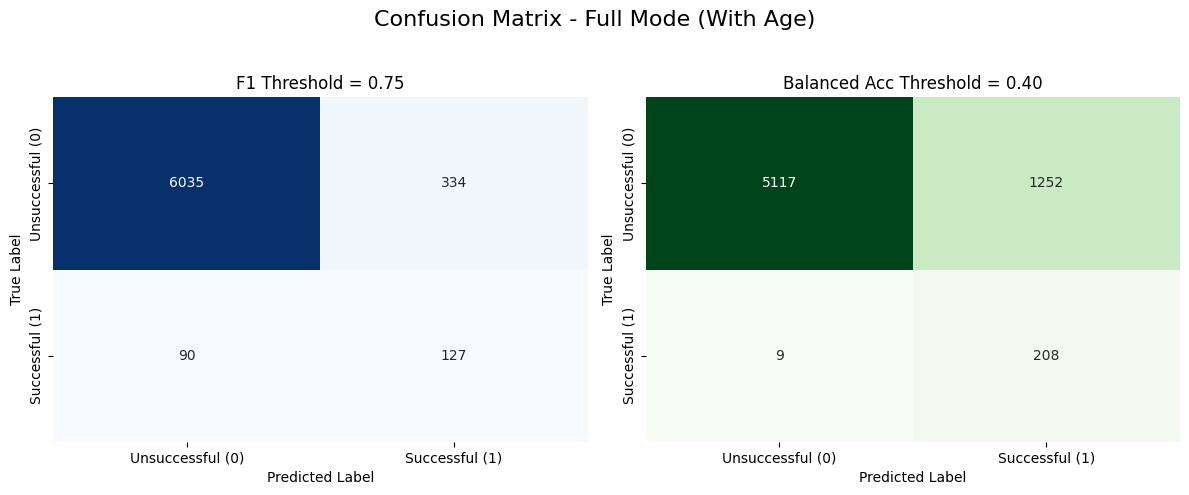

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# CONFUSION MATRIX PLOTS SIDE BY SIDE
# ==============================================================================

# Compute confusion matrices
cm_f1 = confusion_matrix(y_test, y_pred_f1)
cm_bal = confusion_matrix(y_test, y_pred_bal)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# F1 Threshold
sns.heatmap(cm_f1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[0])
axes[0].set_title(f"F1 Threshold = {thresholds['F1']:.2f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

#  Balanced Accuracy Threshold 
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[1])
axes[1].set_title(f"Balanced Acc Threshold = {thresholds['Balanced_Accuracy']:.2f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Overall title
plt.suptitle("Confusion Matrix - Full Mode (With Age)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("Confusion Matrix - Full Mode")
plt.show()


# visualize the comparison of the models based on different metrics.

In [13]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade scikit-learn imbalanced-learn optuna joblib matplotlib pandas numpy

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\python\python.exe -m pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import joblib

# Load the realistic mode model
lr_realistic_model = joblib.load("LR_realistic_model.pkl")

# Load the full mode model
lr_full_model = joblib.load("LR_full_model.pkl")

print("Realistic Model Metrics (F1 Optimal Threshold):")
print(lr_realistic_model['metrics_f1'])

print("\nFull Model Metrics (F1 Optimal Threshold):")
print(lr_full_model['metrics_f1'])

print("\nRealistic Model Metrics (Balanced Accuracy Optimal Threshold):")
print(lr_realistic_model['metrics_balanced_accuracy'])

print("\nFull Model Metrics (Balanced Accuracy Optimal Threshold):")
print(lr_full_model['metrics_balanced_accuracy'])

Realistic Model Metrics (F1 Optimal Threshold):
{'balanced_accuracy': 0.6874054409571708, 'precision': 0.28343949044585987, 'recall': 0.41013824884792627, 'f1': 0.3352165725047081, 'roc_auc': 0.9161310582002543, 'geometric_mean': np.float64(0.6290064740822449), 'matthews_corrcoef': 0.3139856743732795, 'cohen_kappa': 0.30826120462139484}

Full Model Metrics (F1 Optimal Threshold):
{'balanced_accuracy': 0.7664059713198941, 'precision': 0.2754880694143167, 'recall': 0.5852534562211982, 'f1': 0.3746312684365782, 'roc_auc': 0.93507723542823, 'geometric_mean': np.float64(0.7446891157712775), 'matthews_corrcoef': 0.37276569047574176, 'cohen_kappa': 0.34529641281111423}

Realistic Model Metrics (Balanced Accuracy Optimal Threshold):
{'balanced_accuracy': 0.8515226764432848, 'precision': 0.12740076824583868, 'recall': 0.9170506912442397, 'f1': 0.2237211916807195, 'roc_auc': 0.9161310582002543, 'geometric_mean': np.float64(0.8489976135263168), 'matthews_corrcoef': 0.29504176888687367, 'cohen_kap

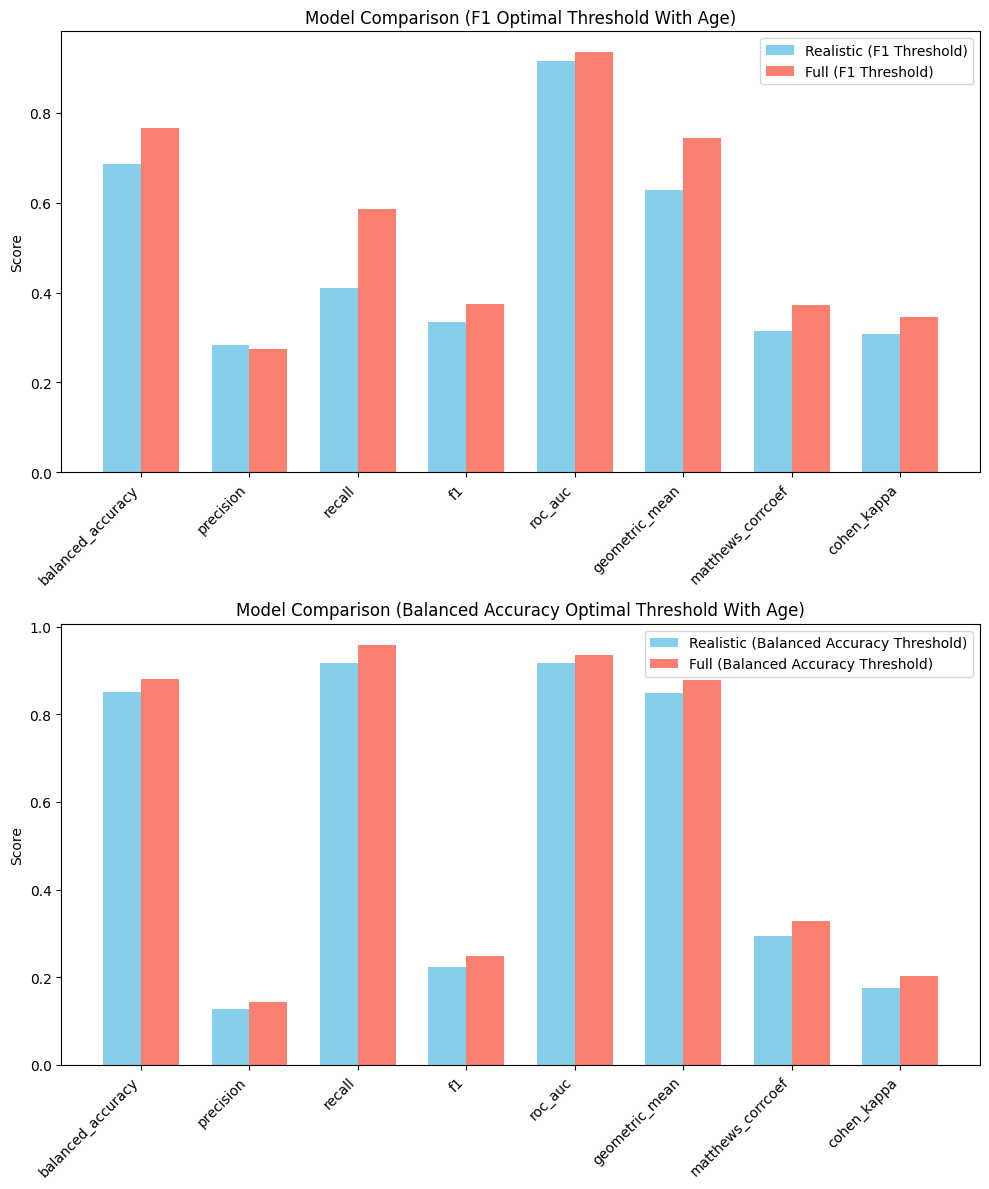

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract metrics for comparison
metrics_f1_realistic = lr_realistic_model['metrics_f1']
metrics_f1_full = lr_full_model['metrics_f1']
metrics_bal_realistic = lr_realistic_model['metrics_balanced_accuracy']
metrics_bal_full = lr_full_model['metrics_balanced_accuracy']

# Create DataFrames for easier plotting
df_f1 = pd.DataFrame({
    "Metric": metrics_f1_realistic.keys(),
    "Realistic (F1 Threshold)": metrics_f1_realistic.values(),
    "Full (F1 Threshold)": metrics_f1_full.values()
})

df_bal = pd.DataFrame({
    "Metric": metrics_bal_realistic.keys(),
    "Realistic (Balanced Accuracy Threshold)": metrics_bal_realistic.values(),
    "Full (Balanced Accuracy Threshold)": metrics_bal_full.values()
})

# Create a 2x1 grid of plots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plotting F1-optimal threshold metrics in the first subplot
bar_width = 0.35
x_f1 = np.arange(len(df_f1["Metric"]))

rects1_f1 = axes[0].bar(x_f1 - bar_width/2, df_f1["Realistic (F1 Threshold)"], bar_width, label='Realistic (F1 Threshold)', color='skyblue')
rects2_f1 = axes[0].bar(x_f1 + bar_width/2, df_f1["Full (F1 Threshold)"], bar_width, label='Full (F1 Threshold)', color='salmon')

axes[0].set_ylabel("Score")
axes[0].set_title("Model Comparison (F1 Optimal Threshold With Age)")
axes[0].set_xticks(x_f1)
axes[0].set_xticklabels(df_f1["Metric"], rotation=45, ha='right')
axes[0].legend()

# Plotting Balanced Accuracy-optimal threshold metrics in the second subplot
bar_width = 0.35
x_bal = np.arange(len(df_bal["Metric"]))

rects1_bal = axes[1].bar(x_bal - bar_width/2, df_bal["Realistic (Balanced Accuracy Threshold)"], bar_width, label='Realistic (Balanced Accuracy Threshold)', color='skyblue')
rects2_bal = axes[1].bar(x_bal + bar_width/2, df_bal["Full (Balanced Accuracy Threshold)"], bar_width, label='Full (Balanced Accuracy Threshold)', color='salmon')

axes[1].set_ylabel("Score")
axes[1].set_title("Model Comparison (Balanced Accuracy Optimal Threshold With Age)")
axes[1].set_xticks(x_bal)
axes[1].set_xticklabels(df_bal["Metric"], rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
# Save the combined 2x1 plot
plt.savefig("model_comparison_2x1_grid.png")
plt.show()

Reading file...
Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=full -> Keeping CA and PA

Features: 69  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


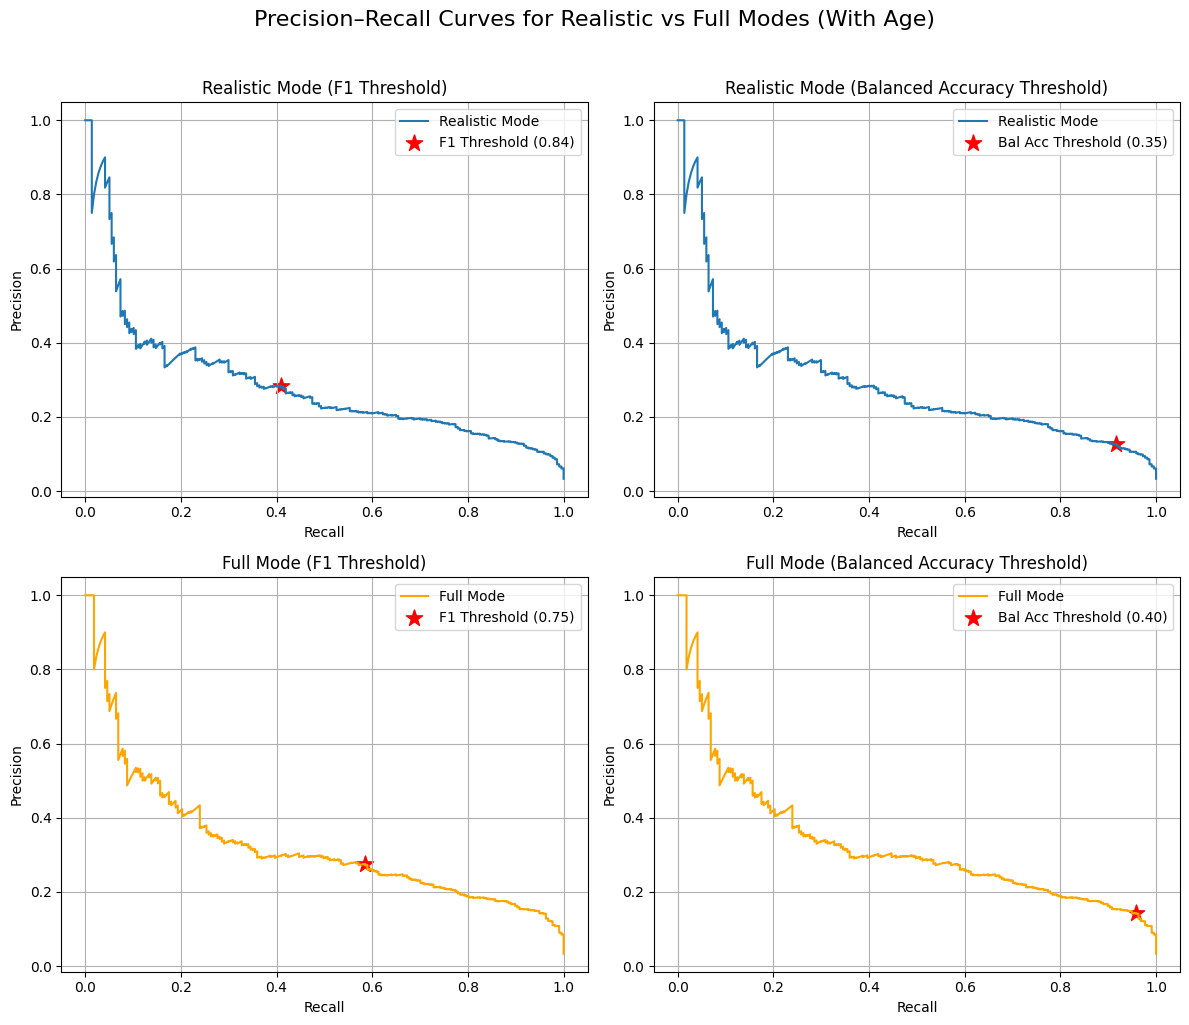

In [16]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# ==============================================================================
# CONFIGURATION
# ==============================================================================
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

MODE = "full"  
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

if 'Age' in df.columns:
    df['Age_Group_Young'] = (df['Age'] <= 20).astype(int)
    df['Age_Group_Peak'] = ((df['Age'] > 20) & (df['Age'] <= 23)).astype(int)

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=VAL_SIZE + TEST_SIZE,
    stratify=y,
    random_state=SEED
)

# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=SEED
)

# Separate X_test for realistic and full models
X_test_realistic = X_test.drop(
    columns=[c for c in ["CA", "PA", "Growth_Ratio", "Growth_Room"] if c in X_test.columns],
    errors='ignore'
)
X_test_full = X_test.copy()  


# ==============================================================================
# Plotting Precision-Recall Curves (2x2 Grid)
# ==============================================================================

# Get predicted probabilities for the test set for both models
y_test_pred_prop_realistic = lr_realistic_model['model'].predict_proba(X_test_realistic)[:, 1]
y_test_pred_prop_full = lr_full_model['model'].predict_proba(X_test_full)[:, 1]

# Calculate precision and recall for different thresholds for realistic model
precision_realistic, recall_realistic, thresholds_realistic = precision_recall_curve(
    y_test, y_test_pred_prop_realistic
)

# Calculate precision and recall for different thresholds for full model
precision_full, recall_full, thresholds_full = precision_recall_curve(
    y_test, y_test_pred_prop_full
)

# Get the optimal thresholds from the loaded models
f1_threshold_realistic = lr_realistic_model['thresholds']['F1']
bal_acc_threshold_realistic = lr_realistic_model['thresholds']['Balanced_Accuracy']
f1_threshold_full = lr_full_model['thresholds']['F1']
bal_acc_threshold_full = lr_full_model['thresholds']['Balanced_Accuracy']

# Find the precision and recall values at the optimal thresholds
f1_idx_realistic = np.argmax(thresholds_realistic >= f1_threshold_realistic) if np.any(
    thresholds_realistic >= f1_threshold_realistic
) else len(thresholds_realistic) - 1
f1_precision_realistic = precision_realistic[f1_idx_realistic]
f1_recall_realistic = recall_realistic[f1_idx_realistic]

bal_acc_idx_realistic = np.argmax(thresholds_realistic >= bal_acc_threshold_realistic) if np.any(
    thresholds_realistic >= bal_acc_threshold_realistic
) else len(thresholds_realistic) - 1
bal_acc_precision_realistic = precision_realistic[bal_acc_idx_realistic]
bal_acc_recall_realistic = recall_realistic[bal_acc_idx_realistic]

f1_idx_full = np.argmax(thresholds_full >= f1_threshold_full) if np.any(
    thresholds_full >= f1_threshold_full
) else len(thresholds_full) - 1
f1_precision_full = precision_full[f1_idx_full]
f1_recall_full = recall_full[f1_idx_full]

bal_acc_idx_full = np.argmax(thresholds_full >= bal_acc_threshold_full) if np.any(
    thresholds_full >= bal_acc_threshold_full
) else len(thresholds_full) - 1
bal_acc_precision_full = precision_full[bal_acc_idx_full]
bal_acc_recall_full = recall_full[bal_acc_idx_full]

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Realistic Mode (F1 Threshold)
axes[0, 0].plot(recall_realistic, precision_realistic, label='Realistic Mode', linestyle='-')
axes[0, 0].scatter(
    f1_recall_realistic, f1_precision_realistic,
    color='red', marker='*', s=150,
    label=f'F1 Threshold ({f1_threshold_realistic:.2f})'
)
axes[0, 0].set_xlabel("Recall")
axes[0, 0].set_ylabel("Precision")
axes[0, 0].set_title("Realistic Mode (F1 Threshold)")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot Realistic Mode (Balanced Accuracy Threshold)
axes[0, 1].plot(recall_realistic, precision_realistic, label='Realistic Mode', linestyle='-')
axes[0, 1].scatter(
    bal_acc_recall_realistic, bal_acc_precision_realistic,
    color='red', marker='*', s=150,
    label=f'Bal Acc Threshold ({bal_acc_threshold_realistic:.2f})'
)
axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].set_title("Realistic Mode (Balanced Accuracy Threshold)")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot Full Mode (F1 Threshold)
axes[1, 0].plot(recall_full, precision_full, label='Full Mode', color='orange', linestyle='-')
axes[1, 0].scatter(
    f1_recall_full, f1_precision_full,
    color='red', marker='*', s=150,
    label=f'F1 Threshold ({f1_threshold_full:.2f})'
)
axes[1, 0].set_xlabel("Recall")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].set_title("Full Mode (F1 Threshold)")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot Full Mode (Balanced Accuracy Threshold)
axes[1, 1].plot(recall_full, precision_full, label='Full Mode', color='orange', linestyle='-')
axes[1, 1].scatter(
    bal_acc_recall_full, bal_acc_precision_full,
    color='red', marker='*', s=150,
    label=f'Bal Acc Threshold ({bal_acc_threshold_full:.2f})'
)
axes[1, 1].set_xlabel("Recall")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].set_title("Full Mode (Balanced Accuracy Threshold)")
axes[1, 1].legend()
axes[1, 1].grid(True)

fig.suptitle(
    "Precision–Recall Curves for Realistic vs Full Modes (With Age)",
    fontsize=16,
    y=1.02
)

plt.tight_layout()
plt.savefig("precision_recall_4grid.png")
plt.show()

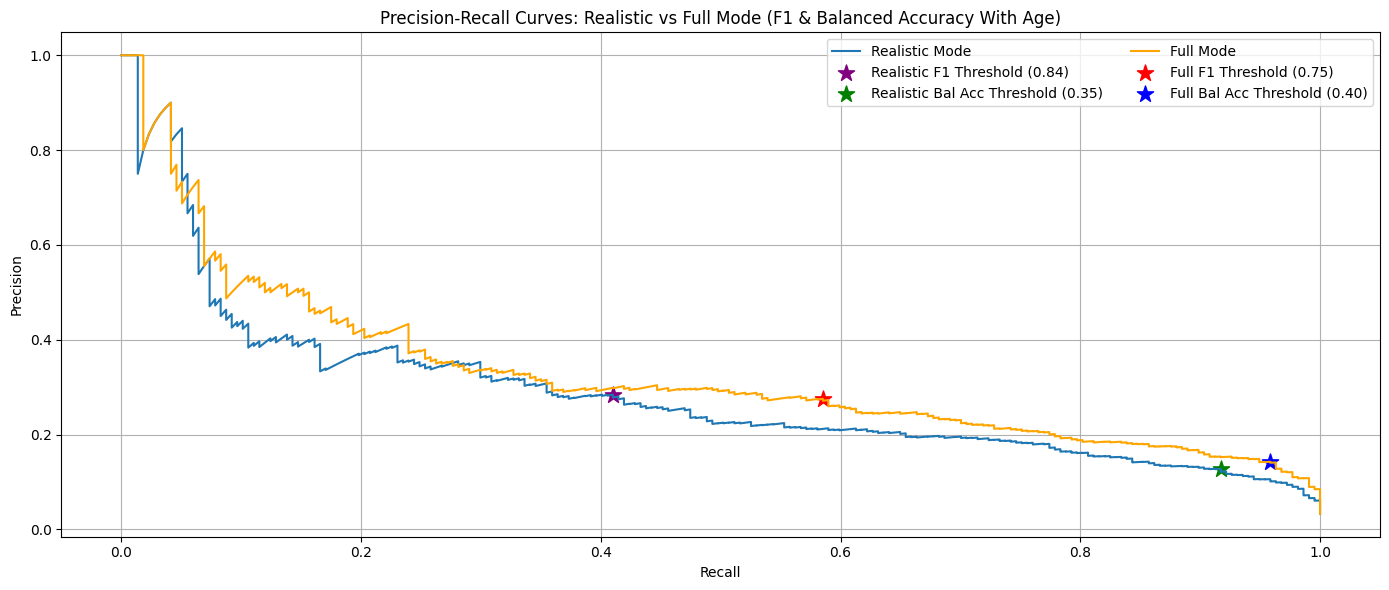

In [17]:
plt.figure(figsize=(14, 6))

# Realistic Mode 
plt.plot(recall_realistic, precision_realistic, label='Realistic Mode', linestyle='-')
plt.scatter(f1_recall_realistic, f1_precision_realistic, color='purple', marker='*', s=150,
            label=f'Realistic F1 Threshold ({f1_threshold_realistic:.2f})')
plt.scatter(bal_acc_recall_realistic, bal_acc_precision_realistic, color='green', marker='*', s=150,
            label=f'Realistic Bal Acc Threshold ({bal_acc_threshold_realistic:.2f})')

#  Full Mode 
plt.plot(recall_full, precision_full, label='Full Mode', color='orange', linestyle='-')
plt.scatter(f1_recall_full, f1_precision_full, color='red', marker='*', s=150,
            label=f'Full F1 Threshold ({f1_threshold_full:.2f})')
plt.scatter(bal_acc_recall_full, bal_acc_precision_full, color='blue', marker='*', s=150,
            label=f'Full Bal Acc Threshold ({bal_acc_threshold_full:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves: Realistic vs Full Mode (F1 & Balanced Accuracy With Age)")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_combined.png")
plt.show()

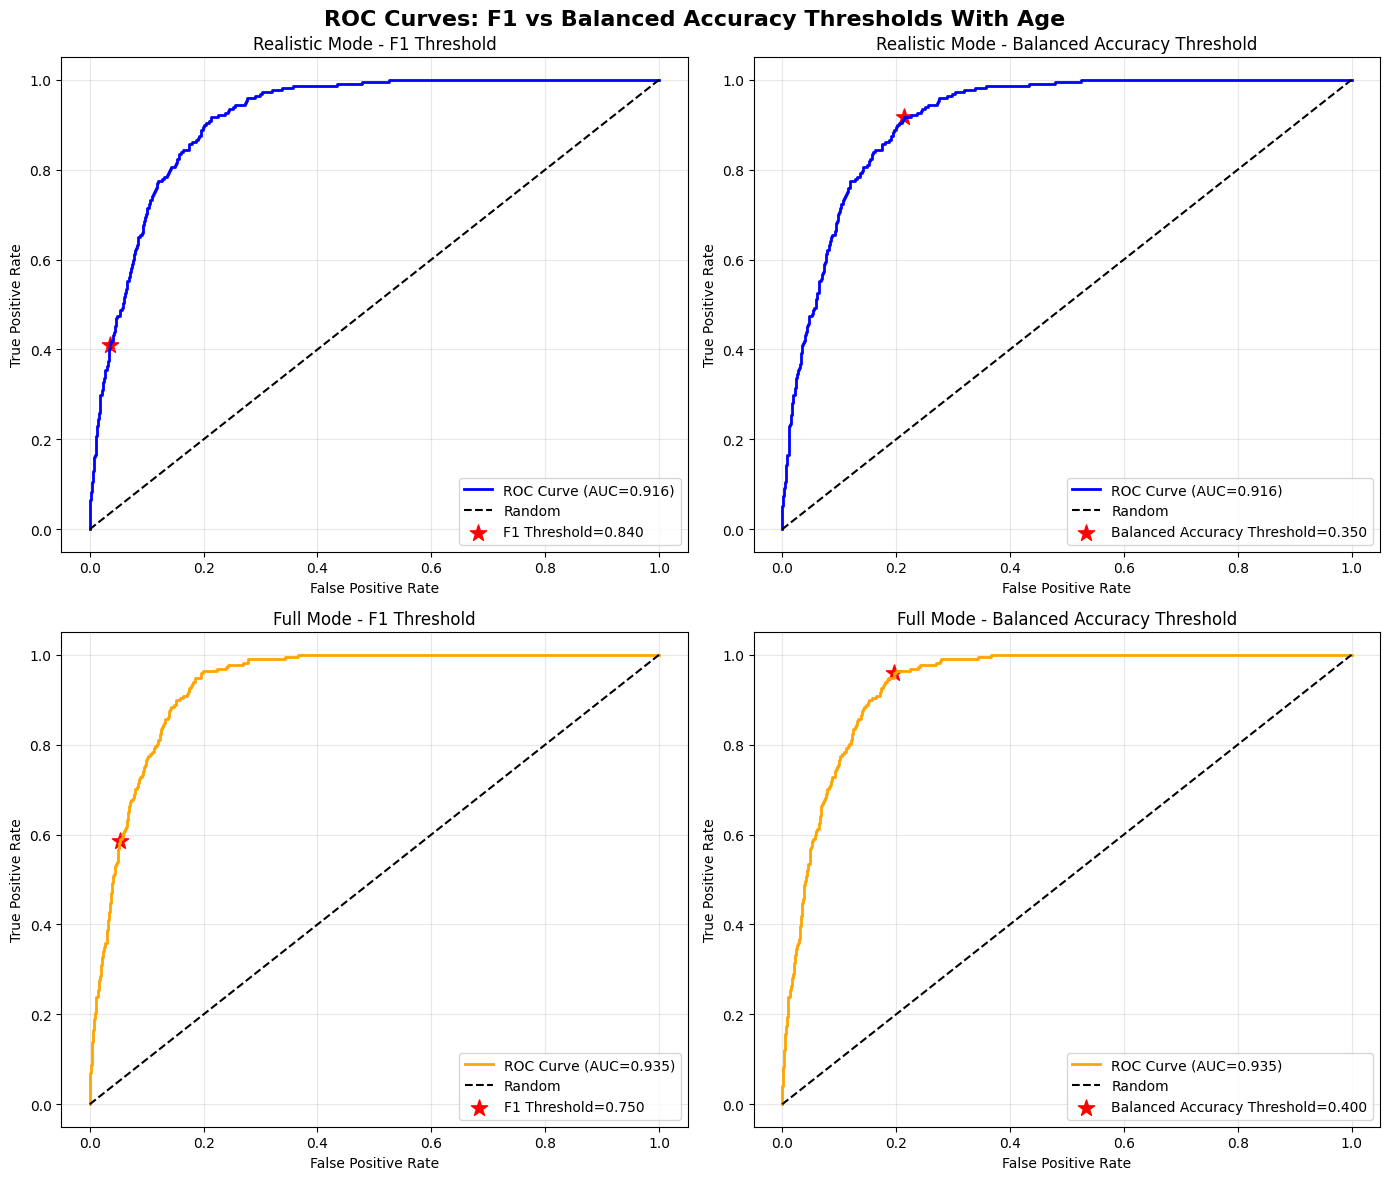

In [18]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Helper function to compute FPR/TPR for a threshold
def roc_point(y_true, y_pred_prop, threshold):
    y_pred = (y_pred_prop >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('ROC Curves: F1 vs Balanced Accuracy Thresholds With Age', fontsize=16, fontweight='bold')

# -----------------------------
# Realistic Mode
# -----------------------------
fpr_real, tpr_real, _ = roc_curve(y_test, y_test_pred_prop_realistic)
roc_auc_real = auc(fpr_real, tpr_real)

# F1 Threshold
fpr_f1_real, tpr_f1_real = roc_point(y_test, y_test_pred_prop_realistic, lr_realistic_model['thresholds']['F1'])
axes[0, 0].plot(fpr_real, tpr_real, 'b-', linewidth=2, label=f'ROC Curve (AUC={roc_auc_real:.3f})')
axes[0, 0].plot([0,1], [0,1], 'k--', label='Random')
axes[0, 0].scatter(fpr_f1_real, tpr_f1_real, color='red', s=150, marker='*',
                   label=f'F1 Threshold={lr_realistic_model["thresholds"]["F1"]:.3f}')
axes[0, 0].set_title('Realistic Mode - F1 Threshold')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(loc='best')

# Balanced Accuracy Threshold
fpr_bal_real, tpr_bal_real = roc_point(y_test, y_test_pred_prop_realistic, lr_realistic_model['thresholds']['Balanced_Accuracy'])
axes[0, 1].plot(fpr_real, tpr_real, 'b-', linewidth=2, label=f'ROC Curve (AUC={roc_auc_real:.3f})')
axes[0, 1].plot([0,1], [0,1], 'k--', label='Random')
axes[0, 1].scatter(fpr_bal_real, tpr_bal_real, color='red', s=150, marker='*',
                   label=f'Balanced Accuracy Threshold={lr_realistic_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[0, 1].set_title('Realistic Mode - Balanced Accuracy Threshold')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(loc='best')

# -----------------------------
# Full Mode
# -----------------------------
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_pred_prop_full)
roc_auc_full = auc(fpr_full, tpr_full)

# F1 Threshold
fpr_f1_full, tpr_f1_full = roc_point(y_test, y_test_pred_prop_full, lr_full_model['thresholds']['F1'])
axes[1, 0].plot(fpr_full, tpr_full, 'orange', linewidth=2, label=f'ROC Curve (AUC={roc_auc_full:.3f})')
axes[1, 0].plot([0,1], [0,1], 'k--', label='Random')
axes[1, 0].scatter(fpr_f1_full, tpr_f1_full, color='red', s=150, marker='*',
                   label=f'F1 Threshold={lr_full_model["thresholds"]["F1"]:.3f}')
axes[1, 0].set_title('Full Mode - F1 Threshold')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(loc='best')

# Balanced Accuracy Threshold
fpr_bal_full, tpr_bal_full = roc_point(y_test, y_test_pred_prop_full, lr_full_model['thresholds']['Balanced_Accuracy'])
axes[1, 1].plot(fpr_full, tpr_full, 'orange', linewidth=2, label=f'ROC Curve (AUC={roc_auc_full:.3f})')
axes[1, 1].plot([0,1], [0,1], 'k--', label='Random')
axes[1, 1].scatter(fpr_bal_full, tpr_bal_full, color='red', s=150, marker='*',
                   label=f'Balanced Accuracy Threshold={lr_full_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[1, 1].set_title('Full Mode - Balanced Accuracy Threshold')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(loc='best')

plt.tight_layout()
plt.savefig("roc_2x2_grid.png", dpi=300, bbox_inches='tight')
plt.show()

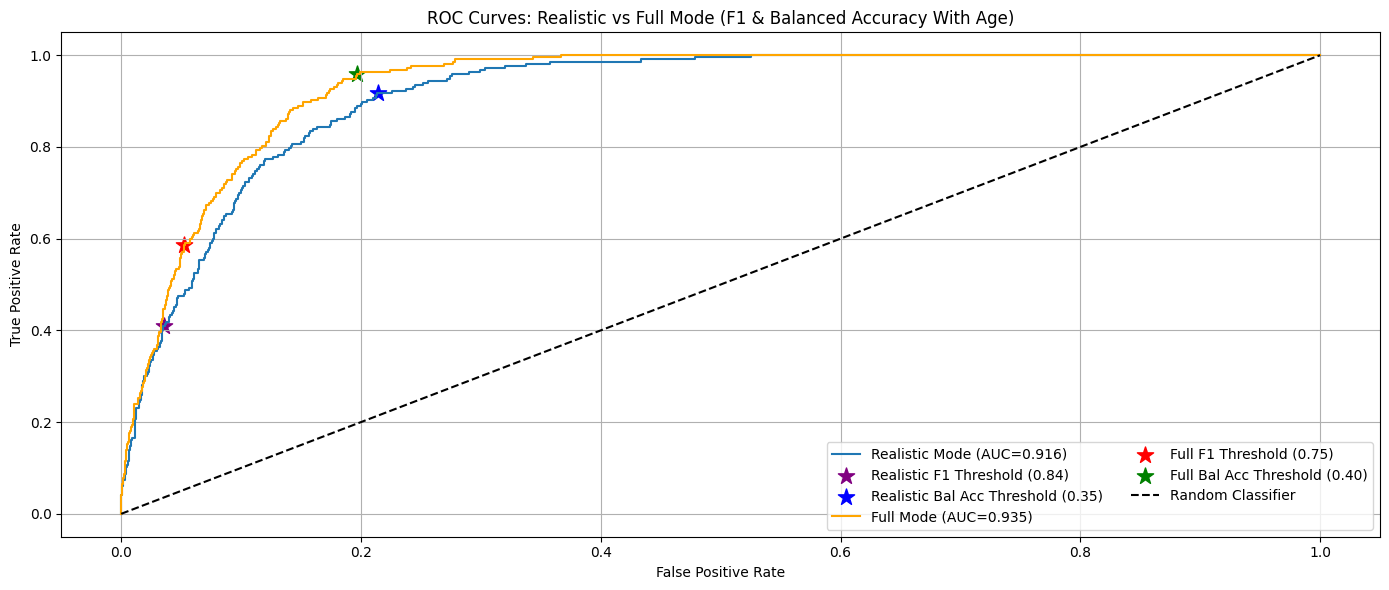

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curves
fpr_real, tpr_real, _ = roc_curve(y_test, y_test_pred_prop_realistic)
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_pred_prop_full)

roc_auc_real = auc(fpr_real, tpr_real)
roc_auc_full = auc(fpr_full, tpr_full)

# Compute points for thresholds
def roc_point(y_true, y_pred_prop, threshold):
    y_pred = (y_pred_prop >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

fpr_f1_real, tpr_f1_real = roc_point(y_test, y_test_pred_prop_realistic, lr_realistic_model['thresholds']['F1'])
fpr_bal_real, tpr_bal_real = roc_point(y_test, y_test_pred_prop_realistic, lr_realistic_model['thresholds']['Balanced_Accuracy'])

fpr_f1_full, tpr_f1_full = roc_point(y_test, y_test_pred_prop_full, lr_full_model['thresholds']['F1'])
fpr_bal_full, tpr_bal_full = roc_point(y_test, y_test_pred_prop_full, lr_full_model['thresholds']['Balanced_Accuracy'])

# Plot combined ROC
plt.figure(figsize=(14, 6))

# Realistic Mode 
plt.plot(fpr_real, tpr_real, label=f'Realistic Mode (AUC={roc_auc_real:.3f})', linestyle='-')
plt.scatter(fpr_f1_real, tpr_f1_real, color='purple', marker='*', s=150,
            label=f'Realistic F1 Threshold ({lr_realistic_model["thresholds"]["F1"]:.2f})')
plt.scatter(fpr_bal_real, tpr_bal_real, color='blue', marker='*', s=150,
            label=f'Realistic Bal Acc Threshold ({lr_realistic_model["thresholds"]["Balanced_Accuracy"]:.2f})')

#  Full Mode 
plt.plot(fpr_full, tpr_full, label=f'Full Mode (AUC={roc_auc_full:.3f})', color='orange', linestyle='-')
plt.scatter(fpr_f1_full, tpr_f1_full, color='red', marker='*', s=150,
            label=f'Full F1 Threshold ({lr_full_model["thresholds"]["F1"]:.2f})')
plt.scatter(fpr_bal_full, tpr_bal_full, color='green', marker='*', s=150,
            label=f'Full Bal Acc Threshold ({lr_full_model["thresholds"]["Balanced_Accuracy"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Realistic vs Full Mode (F1 & Balanced Accuracy With Age)")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_combined.png", dpi=300)
plt.show()

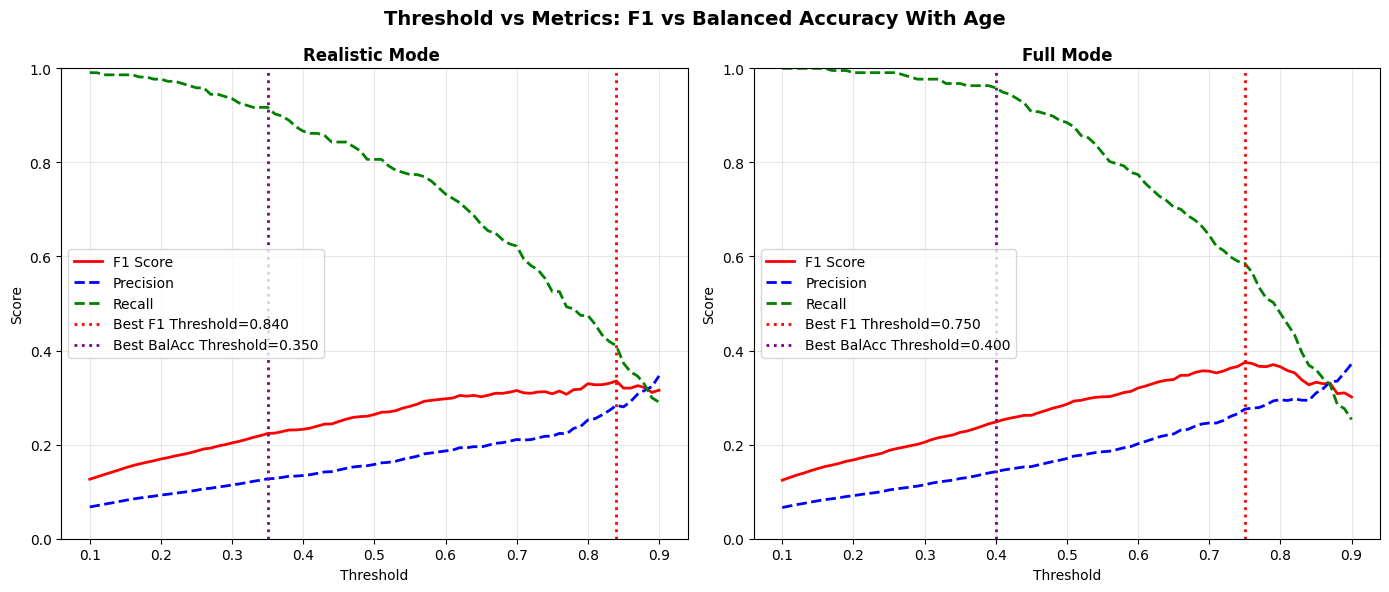

In [20]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Define threshold range
threshold_range = np.arange(0.1, 0.91, 0.01)

def compute_metrics(y_true, y_pred_prop, threshold_range):
    f1_scores, bal_acc_scores, precision_scores, recall_scores = [], [], [], []
    for t in threshold_range:
        y_pred_t = (y_pred_prop >= t).astype(int)
        f1_scores.append(f1_score(y_true, y_pred_t))
        bal_acc_scores.append(balanced_accuracy_score(y_true, y_pred_t))
        precision_scores.append(precision_score(y_true, y_pred_t))
        recall_scores.append(recall_score(y_true, y_pred_t))
    return f1_scores, bal_acc_scores, precision_scores, recall_scores

# Realistic Mode 
f1_scores_real, bal_acc_scores_real, precision_scores_real, recall_scores_real = compute_metrics(
    y_test, y_test_pred_prop_realistic, threshold_range
)

#  Full Mode 
f1_scores_full, bal_acc_scores_full, precision_scores_full, recall_scores_full = compute_metrics(
    y_test, y_test_pred_prop_full, threshold_range
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Threshold vs Metrics: F1 vs Balanced Accuracy With Age', fontsize=14, fontweight='bold')

# Realistic Mode 
axes[0].plot(threshold_range, f1_scores_real, 'r-', linewidth=2, label='F1 Score')
axes[0].plot(threshold_range, precision_scores_real, 'b--', linewidth=2, label='Precision')
axes[0].plot(threshold_range, recall_scores_real, 'g--', linewidth=2, label='Recall')
axes[0].axvline(lr_realistic_model['thresholds']['F1'], color='red', linestyle=':', linewidth=2,
                label=f'Best F1 Threshold={lr_realistic_model["thresholds"]["F1"]:.3f}')
axes[0].axvline(lr_realistic_model['thresholds']['Balanced_Accuracy'], color='purple', linestyle=':', linewidth=2,
                label=f'Best BalAcc Threshold={lr_realistic_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[0].set_title('Realistic Mode ', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best')
axes[0].set_ylim([0, 1])

#  Full Mode 
axes[1].plot(threshold_range, f1_scores_full, 'r-', linewidth=2, label='F1 Score')
axes[1].plot(threshold_range, precision_scores_full, 'b--', linewidth=2, label='Precision')
axes[1].plot(threshold_range, recall_scores_full, 'g--', linewidth=2, label='Recall')
axes[1].axvline(lr_full_model['thresholds']['F1'], color='red', linestyle=':', linewidth=2,
                label=f'Best F1 Threshold={lr_full_model["thresholds"]["F1"]:.3f}')
axes[1].axvline(lr_full_model['thresholds']['Balanced_Accuracy'], color='purple', linestyle=':', linewidth=2,
                label=f'Best BalAcc Threshold={lr_full_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[1].set_title('Full Mode', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig("threshold_vs_metrics_pair_combined.png", dpi=300, bbox_inches='tight')
plt.show()

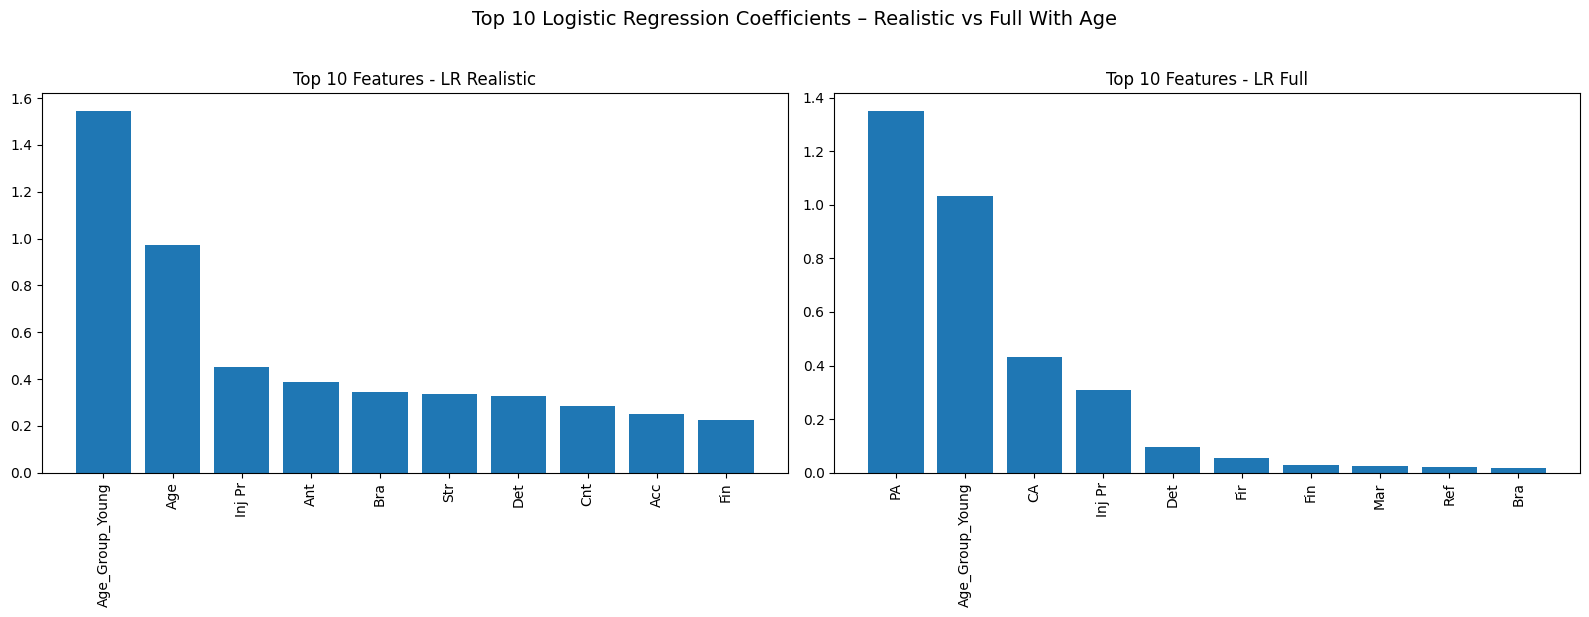

LR Realistic Top 10 Features:
Age_Group_Young: 1.5434
Age: 0.9726
Inj Pr: 0.4502
Ant: 0.3854
Bra: 0.3459
Str: 0.3354
Det: 0.3260
Cnt: 0.2832
Acc: 0.2504
Fin: 0.2230

LR Full Top 10 Features:
PA: 1.3488
Age_Group_Young: 1.0320
CA: 0.4320
Inj Pr: 0.3092
Det: 0.0965
Fir: 0.0554
Fin: 0.0288
Mar: 0.0261
Ref: 0.0204
Bra: 0.0184


In [21]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load saved LR models
model_lr_realistic = joblib.load("LR_realistic_model.pkl")["model"]
model_lr_full = joblib.load("LR_full_model.pkl")["model"]

# Extract coefficients (as importance scores for LR)
# Use absolute values of coefficients
importances_realistic = np.abs(model_lr_realistic.named_steps["clf"].coef_[0])
importances_full = np.abs(model_lr_full.named_steps["clf"].coef_[0])

FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"

# ==============================================================================
# Get feature names for REALISTIC model
# ==============================================================================
try:
    X_realistic_cols = model_lr_realistic.named_steps["scaler"].get_feature_names_out()
except AttributeError:
    df_temp = pd.read_excel(FILE_PATH)
    drop_cols = [
        'UID', 'Name', 'Club', 'Source_File',
        'UID_k1', 'UID_k2', 'UID_k3',
        'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
        'success_k1', 'success_k2', 'success_k3',
        'Transfer Value',
        'Position', 'Nat'
    ]
    df_temp = df_temp.drop(columns=[c for c in drop_cols if c in df_temp.columns], errors='ignore')

    # realistic mode: drop CA/PA and any growth features (if present)
    df_temp_realistic = df_temp.drop(
        columns=[c for c in ["CA", "PA", "Growth_Ratio", "Growth_Room"] if c in df_temp.columns],
        errors='ignore'
    )

    # add age group dummies if Age exists (realistic mode keeps Age)
    if 'Age' in df_temp_realistic.columns:
        df_temp_realistic['Age_Group_Young'] = (df_temp_realistic['Age'] <= 20).astype(int)
        df_temp_realistic['Age_Group_Peak'] = ((df_temp_realistic['Age'] > 20) & (df_temp_realistic['Age'] <= 23)).astype(int)

    X_realistic_cols = df_temp_realistic.drop(columns=["success_label"]).columns

# ==============================================================================
# Get feature names for FULL model
# ==============================================================================
try:
    X_full_cols = model_lr_full.named_steps["scaler"].get_feature_names_out()
except AttributeError:
    df_temp = pd.read_excel(FILE_PATH)
    drop_cols = [
        'UID', 'Name', 'Club', 'Source_File',
        'UID_k1', 'UID_k2', 'UID_k3',
        'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
        'success_k1', 'success_k2', 'success_k3',
        'Transfer Value',
        'Position', 'Nat'
    ]
    df_temp = df_temp.drop(columns=[c for c in drop_cols if c in df_temp.columns], errors='ignore')

    df_temp_full = df_temp.copy()

    # add growth features if PA/CA exist
    if all(col in df_temp_full.columns for col in ["PA", "CA"]):
        df_temp_full["Growth_Ratio"] = df_temp_full["PA"] / df_temp_full["CA"].replace(0, 1)
        df_temp_full["Growth_Room"] = df_temp_full["PA"] - df_temp_full["CA"]

    # add age group dummies if Age exists
    if 'Age' in df_temp_full.columns:
        df_temp_full['Age_Group_Young'] = (df_temp_full['Age'] <= 20).astype(int)
        df_temp_full['Age_Group_Peak'] = ((df_temp_full['Age'] > 20) & (df_temp_full['Age'] <= 23)).astype(int)

    X_full_cols = df_temp_full.drop(columns=["success_label"]).columns

# ==============================================================================
# Get top 10 features
# ==============================================================================
top_n = 10
indices_realistic = np.argsort(importances_realistic)[::-1][:top_n]
indices_full = np.argsort(importances_full)[::-1][:top_n]

top_features_realistic = [X_realistic_cols[i] for i in indices_realistic]
top_importances_realistic = importances_realistic[indices_realistic]

top_features_full = [X_full_cols[i] for i in indices_full]
top_importances_full = importances_full[indices_full]

# ==============================================================================
# Plot side by side
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(range(top_n), top_importances_realistic, align='center')
axes[0].set_xticks(range(top_n))
axes[0].set_xticklabels(top_features_realistic, rotation=90)
axes[0].set_title("Top 10 Features - LR Realistic")

axes[1].bar(range(top_n), top_importances_full, align='center')
axes[1].set_xticks(range(top_n))
axes[1].set_xticklabels(top_features_full, rotation=90)
axes[1].set_title("Top 10 Features - LR Full")

fig.suptitle("Top 10 Logistic Regression Coefficients – Realistic vs Full With Age", fontsize=14, y=1.02)

plt.tight_layout()
plt.savefig("top_10_features_lr_comparison.png")
plt.show()

# ==============================================================================
# Print top 10 features
# ==============================================================================
print("LR Realistic Top 10 Features:")
for f, imp in zip(top_features_realistic, top_importances_realistic):
    print(f"{f}: {imp:.4f}")

print("\nLR Full Top 10 Features:")
for f, imp in zip(top_features_full, top_importances_full):
    print(f"{f}: {imp:.4f}")
